In [ ]:
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import nltk
# nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\yupad\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
# read in data
df = pd.read_csv('Reviews.csv')

In [4]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Quick EDA

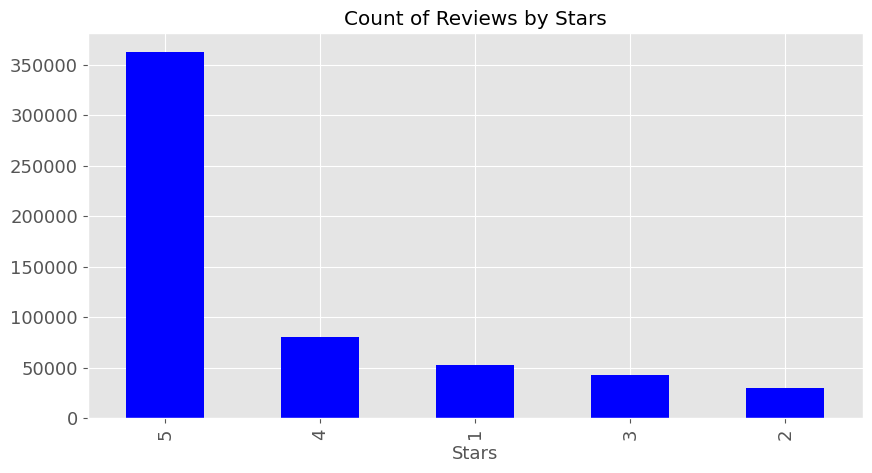

In [5]:
ax = df['Score'].value_counts().plot(kind='bar',title='Count of Reviews by Stars' ,figsize=(10,5), fontsize=13, color='blue')
ax.set_xlabel('Stars', fontsize=13)
plt.show()

Basic NLTK

In [6]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [7]:
tokens = nltk.word_tokenize(example)
print(tokens)

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft', ',', 'I', 'do', "n't", 'like', 'it', '.', 'Quaker', 'Oats', 'is', 'the', 'way', 'to', 'go', '.']


Using VADER
using bag of words approach

In [5]:
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\yupad\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [9]:
sia.polarity_scores('I am very happy today')

{'neg': 0.0, 'neu': 0.429, 'pos': 0.571, 'compound': 0.6115}

In [14]:
sia.polarity_scores('I am very depressed today')

{'neg': 0.545, 'neu': 0.455, 'pos': 0.0, 'compound': -0.5563}

In [15]:
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [16]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [8]:
res = {}
for i, row in tqdm(df.head(500).iterrows(), total=500):  
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)


  0%|          | 0/500 [00:00<?, ?it/s]

In [9]:
# Convert 'res' dictionary to DataFrame
vaders = pd.DataFrame(res).T

# Reset index and rename it to 'Id'
vaders = vaders.reset_index().rename(columns={'index': 'Id'})

# Ensure 'Id' exists in both DataFrames before merging
if 'Id' not in df.columns:
    print("Error: 'Id' column is missing in df")
    
# Perform the merge
vaders = vaders.merge(df, on='Id', how='left')


In [ ]:
# now we have sentimetn score and metadata
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


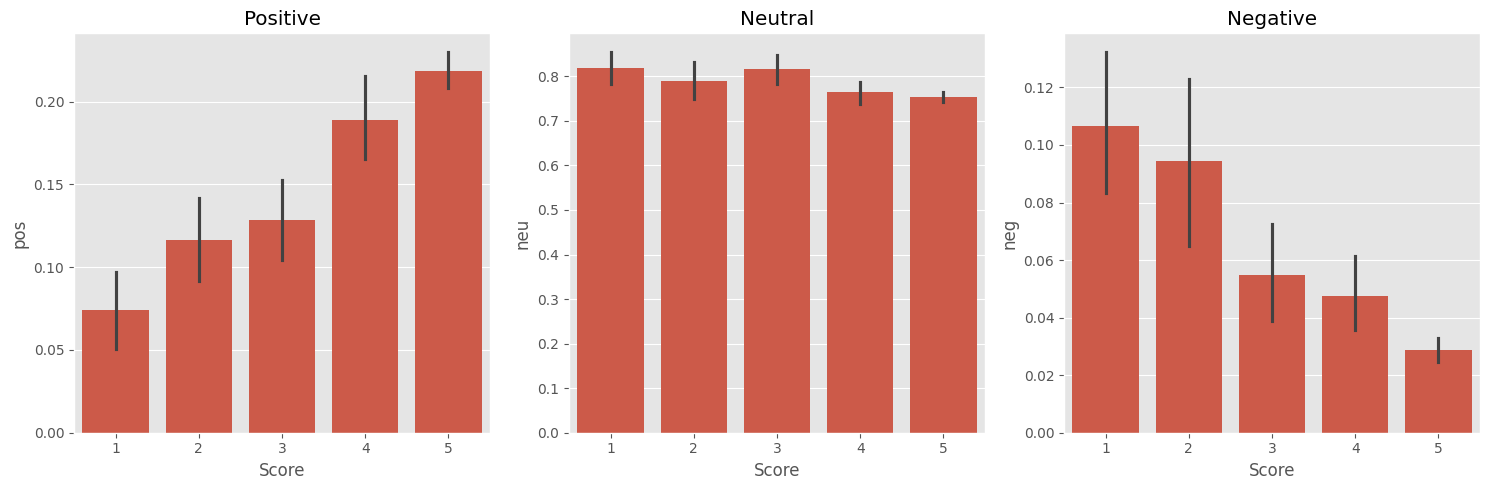

In [14]:
# Plot vader results
fig ,axs = plt.subplots(1,3, figsize=(15,5))
sns.barplot(data = vaders, x='Score', y='pos' , ax = axs[0])
sns.barplot(data = vaders, x='Score', y='neu' , ax = axs[1])
sns.barplot(data = vaders, x='Score', y='neg' , ax = axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()